In [1]:
import os
import progressbar
import networkx as nx
import numpy as np
import pandas as pd
import pickle
import biograph.graph_models as graph_models

os.chdir("../")

### Graph verification and preprocessing

In [2]:
def load_graph(fn):
    with open(fn, "rb") as f:
        return pickle.load(f)
filenames = [fn for fn in os.listdir("graphs/") if ".pkl" in fn]
#filenames = ["3KEU.pkl"]
graphs = [load_graph("graphs/"+fn) for fn in filenames]
print("Loaded {} graphs".format(len(graphs)))

Loaded 1228 graphs


In [3]:
for i in progressbar.progressbar(range(len(graphs))):
    graphs[i] = graph_models.GraphModel.get_diffused_graph(graphs[i], steps=3)

100% (1228 of 1228) |####################| Elapsed Time: 0:42:06 Time:  0:42:06


In [6]:
df.columns

Index(['depth_1', 'depth_2', 'depth_3', 'bfactor_1', 'bfactor_2', 'bfactor_3',
       'depth', 'bfactor', 'chain', 'ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN',
       'GLU', 'GLY', 'HIS', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER',
       'THR', 'TRP', 'TYR', 'VAL', 'UNK', 'x', 'y', 'z', 'target'],
      dtype='object')

In [17]:
import biograph.constants
def touches_ligand(x):
    return x <= 4 or (x<=6 and np.random.binomial(1, 1-(x-4)/2) == 1)
dataframes = {} # chain_id to dataframe
for graph in progressbar.progressbar(graphs):
    df = graph_models.GraphModel.graph_to_dataframe(graph)
    # One hot for AAs
    for code3 in biograph.constants.AMINOACIDS_3 + ["UNK"]:
        df[code3] = (df.resname == code3).astype(np.int)
    
    for i, coord in enumerate(["x", "y", "z"]):
        df[coord] = df.coord.map(lambda x: x[i])
        
    df["target"] = df.distance.map(touches_ligand).astype(np.int)
    df = df[[c for c in df.columns if "distance_" not in c]]
    df = df.drop(["full_id","resname", "coord", "distance"], axis=1)
    for chain in df.chain.unique():
        dataframes[chain] = df.loc[df.chain==chain].drop(["chain"], axis=1)

100% (1228 of 1228) |####################| Elapsed Time: 0:01:51 Time:  0:01:51


In [20]:
print([df.columns for df in list(dataframes.values())[0:1]])

[Index(['depth_1', 'depth_2', 'depth_3', 'bfactor_1', 'bfactor_2', 'bfactor_3',
       'depth', 'bfactor', 'ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU',
       'GLY', 'HIS', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR',
       'TRP', 'TYR', 'VAL', 'UNK', 'x', 'y', 'z', 'target'],
      dtype='object')]


In [ ]:
# todo: class balance

## Example model

### Data splits and preprocessing

In [23]:
with open("names_groups.pkl", "rb")  as f:
    names, groups = pickle.load(f)


In [24]:
# sanity check: each protein's chains belong only to one cluster..?
counter = 0
for pdbid, chains in names.items():
    clusters = [groups[chain] for chain in chains if groups[chain] is not None]
    if len(set(clusters)) > 1:
        counter += 1
        print("There is a protein, {}, with different clusters different chains".format(pdbid))
        print("Groups not ignoring None:",
             [groups[chain] for chain in chains])
        continue
    

There is a protein, 2RD5, with different clusters different chains
Groups not ignoring None: [496, 496, 876, 876]
There is a protein, 5ECP, with different clusters different chains
Groups not ignoring None: [129, 720, 720, 129, 720, 720]
There is a protein, 6REP, with different clusters different chains
Groups not ignoring None: [973, 105, 271, 483, 556, 903, 834, 776, 963, 950, 896, 896, 896, 896, 896, 896, 896, 896, 896, 896, 480, 712, 989, 759, 498, 137, 137, 137, 130, 130, 130]
There is a protein, 2YCH, with different clusters different chains
Groups not ignoring None: [376, 1034]
There is a protein, 4WB5, with different clusters different chains
Groups not ignoring None: [325, 1030]
There is a protein, 6GJS, with different clusters different chains
Groups not ignoring None: [12, 837, 855]
There is a protein, 4EAK, with different clusters different chains
Groups not ignoring None: [939, 965, 471]
There is a protein, 2A40, with different clusters different chains
Groups not ignoring

In [37]:
groups.get("3RRF_A") is not None

True

In [80]:
# Concatenate dataframes and assign groups
for chain in dataframes.keys():
    # usage of .get is intentional (fails on 5A99 that has "no sequences")
    dataframes[chain]["group"] = groups.get(chain) if groups.get(chain) is not None else np.nan

dataset = pd.concat(dataframes, ignore_index=True)
dataset = dataset.loc[dataset.group.notna()]
row_groups = dataset.group
row_target = dataset.target

dataset = dataset.drop(["target", "group"], axis=1)
dataset.head()

,depth_1,depth_2,depth_3,bfactor_1,bfactor_2,bfactor_3,depth,bfactor,ALA,ARG,...,PRO,SER,THR,TRP,TYR,VAL,UNK,x,y,z
0,4.831090,8.812458,11.477131,32.005000,32.487586,32.680500,0.000000,31.48,0,0,...,0,0,0,0,0,0,0,-0.238000,25.985001,108.763000
1,7.833621,11.795527,12.761029,33.264286,34.008571,33.344933,7.372662,29.98,0,0,...,0,0,0,0,0,0,0,5.892000,35.036999,109.164001
2,18.250218,15.994949,14.933361,30.196875,30.426591,31.341667,16.713316,27.82,0,0,...,0,0,0,0,0,1,0,32.373001,33.452999,103.086998
3,15.092253,15.408400,14.320662,31.079286,31.460851,32.973265,13.230346,29.43,0,0,...,0,0,0,0,0,0,0,27.721001,38.990002,104.329002
4,8.365189,9.885454,9.998658,28.811875,31.536170,34.092987,7.021228,27.02,0,0,...,0,0,0,0,0,0,0,28.482000,29.853001,118.865997


In [45]:
# class %
row_target.sum()/row_target.shape[0]*100

2.4939162830671715

[3, 4, 5, 6, 7, 8]

In [111]:
from scipy.stats import uniform
import time
param = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'

groupk= sklearn.model_selection.GroupKFold(n_splits=5)
clf = xgb.XGBClassifier(**param)

#sklearn.model_selection.cross_validate(
#    clf, dataset, y=row_target, groups=row_groups,
#    cv=groupk, n_jobs=1, scoring="roc_auc", verbose=1)

clf = sklearn.model_selection.RandomizedSearchCV(
    clf, {"max_depth": list(range(3,10)), 
          "min_child_weight": uniform(loc=0.5, scale=1.5), # ~U(loc, loc+scale)
          "eta": uniform(loc=0.2, scale=0.3)},
    cv=groupk, n_iter=50, scoring="roc_auc", verbose=5, n_jobs=3)

start = time.time()
search = clf.fit(dataset, row_target, row_groups)
end = time.time()

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:  7.8min
[Parallel(n_jobs=3)]: Done  66 tasks      | elapsed: 36.6min
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed: 88.0min
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed: 139.8min finished


In [112]:
search.cv_results_

{'mean_fit_time': array([153.00882473,  67.99710779,  87.84337502, 128.45810685,
         65.97627244, 124.39312243, 146.84807897,  65.37154164,
        124.72730451,  84.1277205 ,  83.93534164,  49.00324745,
         83.89206939, 124.83399463, 125.88385582,  84.00563135,
        124.57123752, 169.8645607 , 169.59193406,  65.68721991,
        125.28061762,  83.82938218,  48.808916  , 103.71214447,
         65.32078047, 125.06380415,  84.23283682, 103.90013828,
         65.58865566,  83.76010728, 103.55352969,  83.90547209,
        169.9746006 , 169.93108983,  48.5827508 ,  48.76854601,
        147.06119952,  83.95996542, 103.51536012, 124.01645522,
         65.40956531,  48.65864882, 124.57480545, 103.87876768,
         65.1943943 , 146.81846552, 146.92684202,  65.23080859,
         83.87892818,  46.21449156]),
 'std_fit_time': array([2.18035333, 0.32339174, 0.82527784, 0.88632644, 0.78716253,
        0.74458584, 0.95285457, 0.22006419, 0.8448674 , 0.38587987,
        0.33367844, 0.273

In [114]:
search.best_params_, search.best_score_

({'eta': 0.3268179417171394,
  'max_depth': 8,
  'min_child_weight': 0.5460906834882965},
 0.7929988569423073)

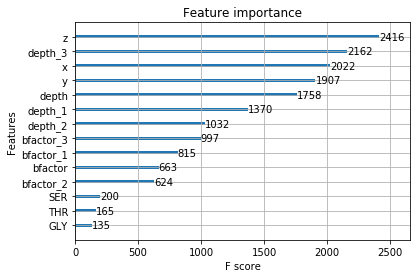

In [122]:

xgb.plot_importance(search.best_estimator_, max_num_features=14)